## Interpolation with grid refinement

The previous notebook introduced how to use yt_xarray's embedded transformation framework. When embedding a non-cartesian dataset within a cartesian grid, however, it is common to end up with null regions of the cartesian dataset where the cartesian bounding box exceeds the underlying bounds of the non-cartesian dataset. To help avoid over-sampling regions with no underlying data, you can utilize several grid-refinement options. 

To illustrate the issue let's first create a global dataset of the upper mantle to a depth of 1000 km and initialize our transformation object:

In [1]:
from yt_xarray.utilities._utilities import (
    construct_minimal_ds,
)
from yt_xarray.transformations import build_interpolated_cartesian_ds, GeocentricCartesian
import yt 

dim_names = ("longitude", "latitude", "depth")


ds = construct_minimal_ds(    
    min_x=0, 
    max_x=360,
    x_stretched=False,
    x_name=dim_names[0],
    n_x=50,
    min_y=-90., 
    max_y=90,
    y_stretched=False,
    y_name=dim_names[1],
    n_y=60,    
    z_stretched=False,
    z_name=dim_names[2],
    n_z=80,
    min_z=0.0,
    max_z=1000.0, 
)

fields = list(ds.data_vars)
gc = GeocentricCartesian(radial_type='depth', r_o=6371., use_neg_lons=True)

In order to resolve the spherical shell in cartesian coordinates on a uniform grid, a fairly high resolution would be needed, resulting in many cells that do not contain data:

yt : [INFO     ] 2024-05-20 14:13:59,570 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-05-20 14:13:59,570 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-05-20 14:13:59,571 Parameters: domain_left_edge          = [-6371. -6371. -6371.]
yt : [INFO     ] 2024-05-20 14:13:59,571 Parameters: domain_right_edge         = [6371. 6371. 6371.]
yt : [INFO     ] 2024-05-20 14:13:59,572 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-05-20 14:14:00,192 xlim = -6371.000000 6371.000000
yt : [INFO     ] 2024-05-20 14:14:00,193 ylim = -6371.000000 6371.000000
yt : [INFO     ] 2024-05-20 14:14:00,194 xlim = -6371.000000 6371.000000
yt : [INFO     ] 2024-05-20 14:14:00,195 ylim = -6371.000000 6371.000000
yt : [INFO     ] 2024-05-20 14:14:00,202 Making a fixed resolution buffer of (('stream', 'test_field')) 800 by 800



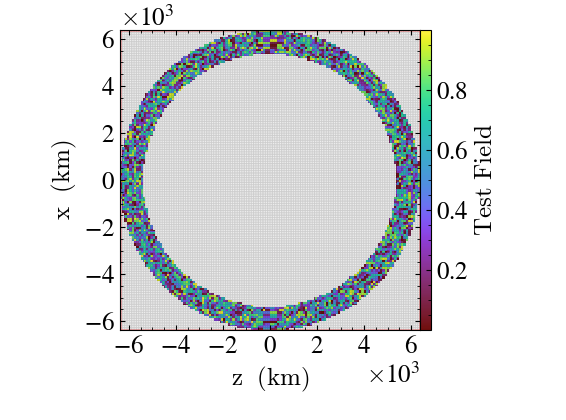

In [2]:
ds_yt = build_interpolated_cartesian_ds(
        ds, 
        gc,
        fields=('test_field',),       
        grid_resolution = (128,128,128),         
    )
    
slc = yt.SlicePlot(ds_yt, 'y', ('test_field'), window_size=(3,3))
slc.set_log('test_field', False)
slc.annotate_cell_edges(alpha=0.2)    
slc.annotate_grids(edgecolors=(1.,0,0,0))
slc.show()

To avoid the over-sampling, `build_interpolated_cartesian_ds` accepts a number of keyword arguments that will subdivide the domain into a number of grid patches. To turn this feature on, provide `refine_grid=True`. When refining, the `grid_resolution` argument is the resolution of the coarsest grid and at present, only a single level of refinement is added. That single level, however, can controlled by the arguments `refine_min_grid_size` and `refine_by`:

* `refine_by` controls the refinement factor and is the number of elements contained within a single coarse grid element.
* `refine_min_grid_size` is the minimum number of **coarse** elements required to subdivide a grid. For example, if `refine_min_grid_size=4`, continuous sections of the coarse grid are only subdivided if they contain more than this number of coarse cells.

yt_xarray : [INFO ] 2024-05-20 14:25:59,483:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-05-20 14:25:59,696:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-05-20 14:25:59,715:  Decomposed into 200 grids after 201 iterations.
yt : [INFO     ] 2024-05-20 14:25:59,762 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-05-20 14:25:59,763 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-05-20 14:25:59,764 Parameters: domain_left_edge          = [-6371. -6371. -6371.]
yt : [INFO     ] 2024-05-20 14:25:59,764 Parameters: domain_right_edge         = [6371. 6371. 6371.]
yt : [INFO     ] 2024-05-20 14:25:59,765 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-05-20 14:25:59,948 xlim = -6371.000000 6371.000000
yt : [INFO     ] 2024-05-20 14:25:59,949 ylim = -6371.000000 6371.000000
yt : [INFO     ] 2024-05-20 14:25:59,951 xlim = -6371.000000 6371.000000
yt : [INFO     ] 2024-05-20 14:25:59,9


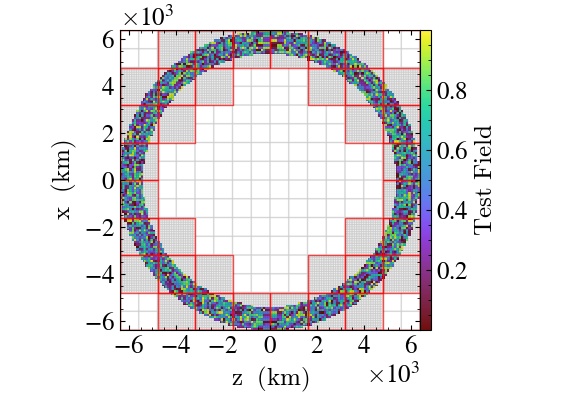

In [4]:
ds_yt = build_interpolated_cartesian_ds(
        ds, 
        gc,
        fields=('test_field',),       
        grid_resolution = (16,16,16),      
        refine_grid=True,                
        refine_by=8,
        refine_min_grid_size=4,
    )

slc = yt.SlicePlot(ds_yt, 'y', ('test_field'), window_size=(3,3))
slc.set_log('test_field', False)
slc.annotate_cell_edges(alpha=0.2)    
slc.annotate_grids(edgecolors=(1.,0,0,0))
slc.show()

The default aglorithm proceeds via bi-section: the coarse grid is iteratively divded in half (in each dimension), discarding empty grids along the way. Additionally, one can use the decomposition method of Berger and Rigoutsos 1991 (https://doi.org/10.1109/21.120081) by specifying `refinement_method='signature_filter'`.

Now let's return to the real world example from the previous notebook: the regional upper mantle tomography model from Schmandt and Humphreys (2010, doi:10.1016/j.epsl.2010.06.047, accessible at doi:10.17611/DP/9991760). 

Without grid refinement:

yt : [INFO     ] 2024-05-20 14:37:27,242 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-05-20 14:37:27,243 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-05-20 14:37:27,243 Parameters: domain_left_edge          = [-3271. -5573.  2533.]
yt : [INFO     ] 2024-05-20 14:37:27,244 Parameters: domain_right_edge         = [ -334. -2832.  4870.]
yt : [INFO     ] 2024-05-20 14:37:27,245 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-05-20 14:37:27,660 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-05-20 14:37:27,660 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-05-20 14:37:27,662 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-05-20 14:37:27,663 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-05-20 14:37:27,664 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



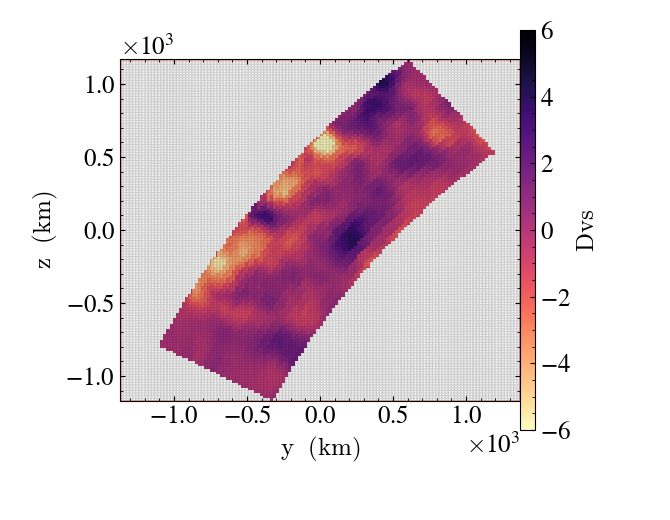

In [10]:
import yt_xarray
ds = yt_xarray.open_dataset("IRIS/wUS-SH-2010_percent.nc")

grid_resolution = (128, 128, 128)
gc = GeocentricCartesian(radial_type='depth', r_o=6371., use_neg_lons=True)
ds_yt = build_interpolated_cartesian_ds(ds, gc, 
                                        fields='dvs', 
                                        length_unit='km',
                                        grid_resolution=grid_resolution)


slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'dvs'), window_size=(4,4))
slc.set_log(("stream", "dvs"), False)
slc.set_cmap(("stream", "dvs"), "magma_r")
slc.set_zlim(("stream", "dvs"), -6, 6)
slc.annotate_cell_edges(alpha=0.2)    
slc.annotate_grids(edgecolors=(1.,0,0,0))
slc.show()

while with grid refinement, we can avoid oversampling those empty regions:

yt_xarray : [INFO ] 2024-05-20 14:38:17,801:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2024-05-20 14:38:18,012:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2024-05-20 14:38:18,031:  Decomposed into 210 grids after 258 iterations.
yt : [INFO     ] 2024-05-20 14:38:18,072 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-05-20 14:38:18,073 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2024-05-20 14:38:18,073 Parameters: domain_left_edge          = [-3271. -5573.  2533.]
yt : [INFO     ] 2024-05-20 14:38:18,074 Parameters: domain_right_edge         = [ -334. -2832.  4870.]
yt : [INFO     ] 2024-05-20 14:38:18,074 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-05-20 14:38:18,367 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-05-20 14:38:18,367 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-05-20 14:38:18,369 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-05-20 14:38:


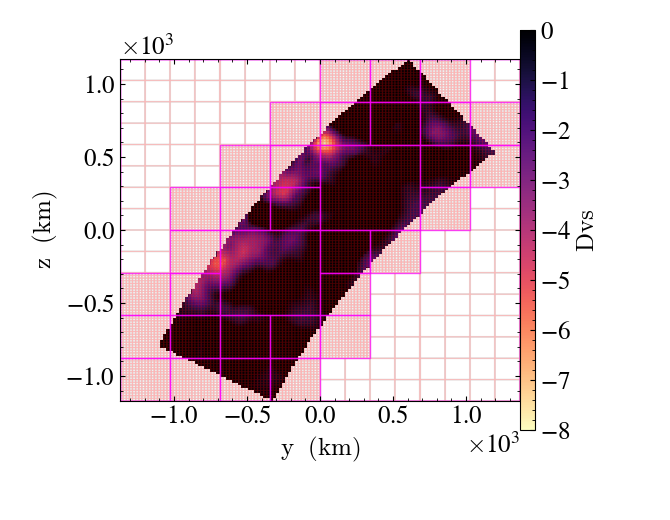

In [14]:
import xarray as xr
import yt_xarray
import yt
from yt_xarray.transformations import GeocentricCartesian, build_interpolated_cartesian_ds

ds = yt_xarray.open_dataset("IRIS/wUS-SH-2010_percent.nc")
grid_resolution = (16, 16, 16)
gc = GeocentricCartesian(radial_type='depth', r_o=6371., use_neg_lons=True)
ds_yt = build_interpolated_cartesian_ds(
    ds,
    gc,
    fields = 'dvs' ,   
    grid_resolution = grid_resolution, 
    refine_grid=True,    
    refine_max_iters=2000,
    refine_min_grid_size=4,
    refine_by=8,
    interp_method='interpolate',
)


slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'dvs'), window_size=(4,4))
slc.set_log(("stream", "dvs"), False)
slc.set_cmap(("stream", "dvs"), "magma_r")
slc.set_zlim(("stream", "dvs"), -8, 0)
slc.annotate_cell_edges(color=(1,0,0), alpha=0.3)
slc.annotate_grids(edgecolors=(1,0,1,1))
slc.show()

as before, we'll add a new derived field for volume rendering that picks up just the slow anomalies and fills null values as 0.0:

yt : [WARNING  ] 2024-05-20 14:39:45,173 Field ('stream', 'slow_dvs') already exists. To override use `force_override=True`.
yt : [INFO     ] 2024-05-20 14:39:45,399 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-05-20 14:39:45,400 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-05-20 14:39:45,402 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-05-20 14:39:45,402 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-05-20 14:39:45,403 Making a fixed resolution buffer of (('stream', 'slow_dvs')) 800 by 800



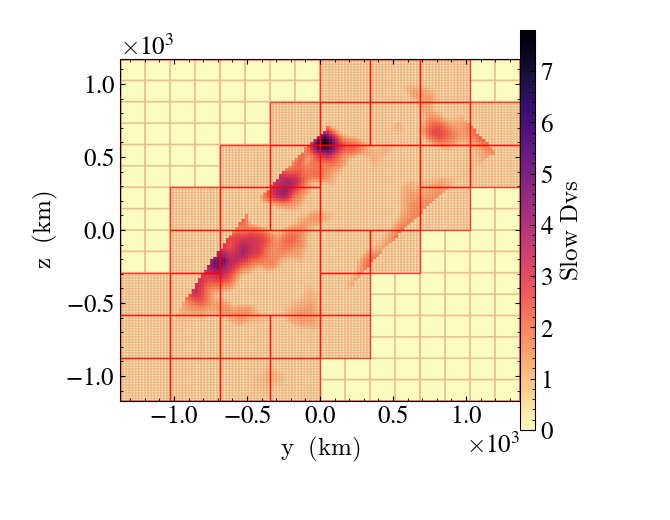

In [16]:
import numpy as np 

fill_val_dict = {'val': 0.0}
def _slow_vels(field, data):
    # return negative velocities only, 0 all other elements
    dvs = data['dvs'].copy()
    dvs[np.isnan(dvs)] = fill_val_dict['val']
    dvs[dvs>0] = fill_val_dict['val']
    return np.abs(dvs)

ds_yt.add_field(
    name=("stream", "slow_dvs"),
    function=_slow_vels,
    sampling_type="local",
)

slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'slow_dvs'), window_size=(4,4))
slc.set_log(("stream", "slow_dvs"), False)
slc.set_cmap(("stream", "slow_dvs"), "magma_r")
slc.annotate_cell_edges(color=(1,0,0), alpha=0.3)
slc.annotate_grids(edgecolors=(1,0,0,1))
slc.show()

and volume rendering again: 

yt : [INFO     ] 2024-05-20 14:39:51,064 Rendering scene (Can take a while).
yt : [INFO     ] 2024-05-20 14:39:51,065 Creating volume
yt : [INFO     ] 2024-05-20 14:39:52,766 Creating transfer function


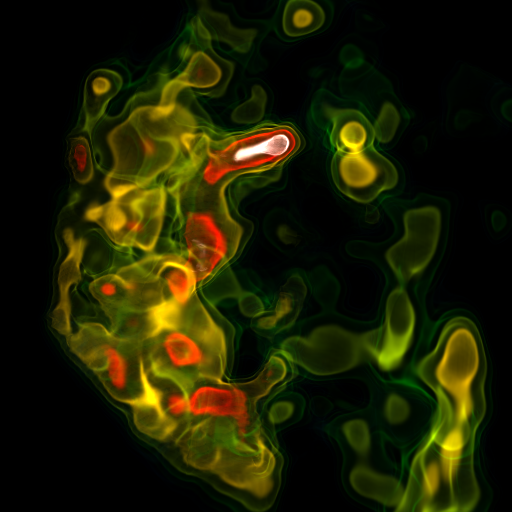

In [17]:
reg = ds_yt.region( ds_yt.domain_center, ds_yt.domain_left_edge, ds_yt.domain_right_edge)
reg

sc = yt.create_scene(reg, field=('stream', 'slow_dvs'))

cam = sc.add_camera(ds_yt)

source = sc[0]

# Set the bounds of the transfer function
source.tfh.set_bounds((0.1, 8))

# set that the transfer function should be evaluated in log space
source.tfh.set_log(True)

cam.zoom(2)
cam.yaw(100*np.pi/180)
cam.roll(220*np.pi/180)
cam.rotate(30*np.pi/180)

sc.show(sigma_clip=5.)